# CS579: Lecture 07  

**Link Prediction**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

# Goal:

- Given a graph $G$ at time $t$, predict which edges will be added at time $t+1$.

# Applications?

<br><br><br><br>
- Introduce potential friends 
- Introduce potential collaborators
- Recommend a movie

In [10]:
# Let's revisit the co-authorship data.
import networkx as nx
import urllib.request
# Fetch co-author network from http://snap.stanford.edu/data/ca-GrQc.html
#urllib.request.urlretrieve("http://snap.stanford.edu/data/ca-GrQc.txt.gz", "ca-GrQc.txt.gz")
graph = nx.read_edgelist('ca-GrQc.txt.gz')

In [11]:
degrees = graph.degree()
author = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[500][0]
print('selected author %s with degree %d' % (author, graph.degree(author)))

selected author 2165 with degree 13


In [14]:
def get_subgraph(graph, node, n=100):
    """ Get the subgraph consisting of this node and its neighbors,
    and their neighbors, up to $n$ total nodes"""
    neighbors = graph.neighbors(node)
    result = set([node])
    for x in neighbors:
        maxsize = n - len(result)
        toadd = set(graph.neighbors(x)) - result
        result.update(list(toadd)[:maxsize])
        if len(result) > n:
            break
    return graph.subgraph(result)

subgraph = get_subgraph(graph, author, n=30)
print('subgraph has %d nodes' % len(subgraph.nodes()))

subgraph has 30 nodes


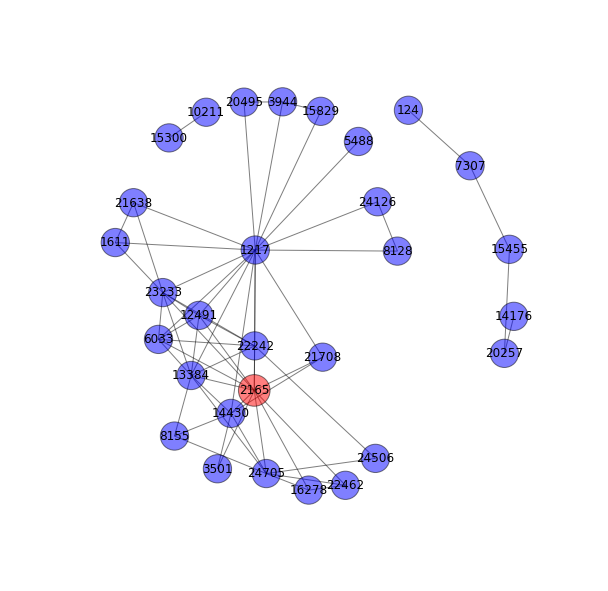

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_subgraph(subgraph, node):
    nodes = subgraph.nodes()
    idx = nodes.index(node)
    colors = ['b'] * len(nodes)
    colors[idx] = 'r'
    sizes = [800] * len(nodes)
    sizes[idx] = 1000
    plt.figure(figsize=(10,10))
    plt.axis('off')
    nx.draw_networkx(subgraph, nodelist=nodes, with_labels=True,
                     width=1, node_color=colors,
                     node_size=sizes, alpha=.5)

plot_subgraph(subgraph, author)

# Approaches


Score each possible new edge $s(X,Y)$.

Higher $s(X,Y)$ $\rightarrow$ more likely for the edge to appear.


# Approaches


Score each possible new edge $s(X,Y)$.

Higher $s(X,Y)$ $\rightarrow$ more likely for the edge to appear.

1.) **Shortest Path:** $s(X,Y) = $ length of shortest path from $X$ to $Y$.

Disadvantages?

In [19]:
from pprint import pprint  # I'm using this to print list of tuples in a more readable way.

def rank_by_shortest_path(graph, node):
    paths = nx.shortest_path_length(graph, node)
    return sorted(paths.items(), key=lambda x: x[1])

shortest_paths = rank_by_shortest_path(graph, author)
pprint([s for s in shortest_paths if s[1] == 2])
# Many shortest paths of length 2!

[('8128', 2),
 ('12735', 2),
 ('11967', 2),
 ('20765', 2),
 ('22876', 2),
 ('14383', 2),
 ('20495', 2),
 ('17089', 2),
 ('21779', 2),
 ('3944', 2),
 ('24942', 2),
 ('8643', 2),
 ('23713', 2),
 ('6533', 2),
 ('10024', 2),
 ('18684', 2),
 ('1150', 2),
 ('1611', 2),
 ('19895', 2),
 ('24506', 2),
 ('24595', 2),
 ('4878', 2),
 ('10211', 2),
 ('14615', 2),
 ('23614', 2),
 ('15829', 2),
 ('9968', 2),
 ('7307', 2),
 ('21638', 2),
 ('2620', 2),
 ('6154', 2),
 ('8155', 2),
 ('9974', 2),
 ('7725', 2),
 ('15066', 2),
 ('3594', 2),
 ('15435', 2),
 ('5184', 2),
 ('21592', 2),
 ('15300', 2),
 ('22523', 2),
 ('543', 2),
 ('15455', 2),
 ('5488', 2),
 ('14165', 2),
 ('19501', 2),
 ('124', 2),
 ('24503', 2),
 ('12453', 2),
 ('20587', 2),
 ('14652', 2),
 ('3452', 2),
 ('25911', 2),
 ('24126', 2),
 ('269', 2),
 ('20257', 2),
 ('14176', 2),
 ('25648', 2),
 ('140', 2),
 ('6442', 2),
 ('19865', 2),
 ('20942', 2),
 ('17681', 2),
 ('19877', 2),
 ('24204', 2)]


# Approaches

**Idea:** If $X$ and $Y$ have many co-authors who have co-authored, then $X$ and $Y$ are more likely to co-author.

 2.) **Common Neighbors:** $$|N(X) \cap N(Y)|$$

In [23]:
from collections import Counter

def rank_by_common_neighbors(graph, node):
    neighbors = set(graph.neighbors(node))
    scores = []
    for n in graph.nodes():
        neighbors2 = set(graph.neighbors(n))
        scores.append((n, len(neighbors & neighbors2)))
    return sorted(scores, key=lambda x: x[1], reverse=True)

common_neighbors = rank_by_common_neighbors(graph, author)
print('Histogram of number of nodes with common neighbors:\n', \
    Counter([x[1] for x in common_neighbors if x[1] > 1]))
pprint(common_neighbors[:20])

Histogram of number of nodes with common neighbors:
 Counter({2: 15, 5: 4, 7: 2, 3: 1, 4: 1, 6: 1, 13: 1})
[('2165', 13),
 ('13384', 7),
 ('1217', 7),
 ('14430', 6),
 ('22242', 5),
 ('6033', 5),
 ('12491', 5),
 ('23233', 5),
 ('24705', 4),
 ('8155', 3),
 ('21708', 2),
 ('22876', 2),
 ('14181', 2),
 ('19895', 2),
 ('1611', 2),
 ('24506', 2),
 ('22523', 2),
 ('3501', 2),
 ('21638', 2),
 ('22462', 2)]


# Approaches

**Idea:** If $X$ and $Y$ have many co-authors who have co-authored, then $X$ and $Y$ are more likely to co-author.

 3.) **Jaccard coefficient:** $$\frac{|N(X) \cap N(Y)|}{|N(X) \cup N(Y)|}$$
 
 For a randomly selected node $Z \in N(X) \cup N(Y)$, how likely is it that $Z$ is in both $N(X)$ and $N(Y)$?

In [21]:
def rank_by_jaccard(graph, node):
    neighbors = set(graph.neighbors(node))
    scores = []
    for n in graph.nodes():
        neighbors2 = set(graph.neighbors(n))
        scores.append((n, 1. * len(neighbors & neighbors2) / len(neighbors | neighbors2)))
    return sorted(scores, key=lambda x: x[1], reverse=True)

common_jaccard = rank_by_jaccard(graph, author)
pprint(common_jaccard[:20])

[('2165', 1.0),
 ('6033', 0.35714285714285715),
 ('13384', 0.3181818181818182),
 ('23233', 0.3125),
 ('22242', 0.2777777777777778),
 ('14430', 0.2727272727272727),
 ('24705', 0.25),
 ('1217', 0.23333333333333334),
 ('12491', 0.21739130434782608),
 ('8155', 0.2),
 ('21708', 0.14285714285714285),
 ('1611', 0.14285714285714285),
 ('24506', 0.14285714285714285),
 ('21638', 0.14285714285714285),
 ('16278', 0.14285714285714285),
 ('20942', 0.14285714285714285),
 ('19895', 0.13333333333333333),
 ('22462', 0.13333333333333333),
 ('19501', 0.13333333333333333),
 ('14165', 0.10526315789473684)]


# Approaches

 4.) **Preferential attachment:** $$|N(X)| \times |N(Y)|$$

# Approaches

**Idea:** two nodes are similar if they have similar neighbors

 5.) **SimRank:** $$s(X,Y) = \gamma \frac{\sum_{A \in N(X)} \sum_{B \in N(Y)}s(A,B)}{|N(X)| \cdot |N(Y)|}$$
 
 $\gamma \in [0, 1]$ is a tuning parameter.

# Evaluation

**How can I tell which method is best?**

# Train/Test evaluation

1. Create $G'$ by removing $n$ edges $E$ from $G$ at random.
  - $G'$ is the **training** network
  - $G$ is the **testing** network
2. Score all potential edges to add in $G'$.
3. Return $\hat{E}$, the top $n$ edges with highest score.
4. Compute the fraction of predicted edges that are in $G$:
$$\frac{|\hat{E} \cap E|}{|E|}$$

In [22]:
# Evaluate Jaccard using train/test
import random
random.seed(123)

def sample_edges(graph, node, pct=.5):
    """ Randomly remove some edges for node.
    Return:
      the resulting graph G'
      the list of friends of node whose edges were removed.
    """
    edges = graph.edges([node])
    # Sample edges to remove.
    to_remove = random.sample(edges, int(len(edges) * pct))
    # Create the list of friends whose edges we have removed.
    friends = []
    for x in to_remove:
        if x[0] != node:
            friends.append(x[0])
        else:
            friends.append(x[1])
    print('removing %d edges' % len(to_remove))
    # Copy G into G' and remove the edges.
    graph_cp = graph.copy()
    graph_cp.remove_edges_from(to_remove)
    return graph_cp, friends

train_graph, friends = sample_edges(graph, author)
prediction = rank_by_jaccard(train_graph, author)[1:7]
print('jaccard rank=', prediction)
print('true neighbors=', friends)
n_correct = len(set(friends) & set([x[0] for x in prediction]))
print('Jaccard finds %d/%d for accuracy of %.3f' % (n_correct, len(friends), (1. * n_correct / len(friends))))

removing 6 edges
jaccard rank= [('6033', 0.5), ('24705', 0.3), ('23233', 0.25), ('22242', 0.21428571428571427), ('1217', 0.2), ('12491', 0.15789473684210525)]
true neighbors= ['14181', '24705', '6033', '1217', '14430', '3501']
Jaccard finds 3/6 for accuracy of 0.500
